# Szeregi czasowe, przewidywanie na podstawie danych historycznych

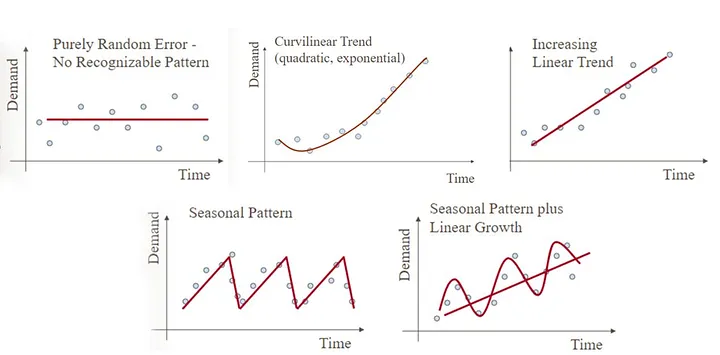

# Wczytanie potrzebnych pakietów i danych

Pracę z danymi zaczynami od wczytania potrzebnych pakietów Python. W tym przypadku jest to Pandas, NumPy, Matplotlib  do analizy  i wizualizacji danych.

Pakiet XGBoost jest pakietem do uczenia maszynowego.

Sklearn.metrics posłuży nam do walidacji modelu metodą średniego błędu kwadratowego

$\displaystyle MSE = \frac{1}{n} \sum_{i=1}^n (y_{pred}-y_{test})^2$, gdzie $n$ - liczba wyników, $y_{pred}$ -wartość przewidziana, $y_{test}$ - wartość testowa danych

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

Do wczytania danych z pliku `.csv` używamy komendy z pakietu Pandas (pd),  `read_csv` i zapisujemy dane w ramce danych (DataFrame) pod nazwą df.

In [2]:
df = pd.read_csv('/content/drive/MyDrive/AEP_hourly.csv')

Wpisanie komendy `df` pokazuje nam zawartość.

In [3]:
df

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


Mamy trzy kolumny. Pierwsza jest w domyśle indeksem numerowanym od `0`. Druga kolumna o nazwie `Datatime` ma format czasowy, trzecia kolumna `AEP_MW` zawiera dane średniej produkcji energii w danej godzienie w jednostakch megawat (MW).

Format danych w ramce `df` możemy sprawdzić wpisując nazwę, czyli `df` z rozszerzeniem `.dtypes`, czyli `df.dtypes`

In [4]:
df.dtypes

,0
Datetime,object
AEP_MW,float64


Widzimy, że `AEP_MW` jest rozumiana jak liczba zmiennoprzecinkowa, natomiast `Datetime` jest traktowana jako obiekt, z którym nie zrobimy analizy danych. Trzeba zamienić na format daty i czasu, czyli `datetime`.

Możemy to zrobić komendą `pd.to_datetime()`, gdzie w nawias wpiszemy co chcemy zamienić na format daty, czyli kolumnę `Datetime` w ramce `df`, czyli możemy zapisać `df.Datatime`. Cała komenda to `pd.to_datetime(df.Datetime)`



In [5]:
pd.to_datetime(df.Datetime)

,Datetime
0,2004-12-31 01:00:00
1,2004-12-31 02:00:00
2,2004-12-31 03:00:00
3,2004-12-31 04:00:00
4,2004-12-31 05:00:00
...,...
121268,2018-01-01 20:00:00
121269,2018-01-01 21:00:00
121270,2018-01-01 22:00:00
121271,2018-01-01 23:00:00


Zmiana w `df` nie zaszła, można to sprawdzić `df.dtypes`

In [6]:
df.dtypes

,0
Datetime,object
AEP_MW,float64


Aby zapisać zmiany należy wskazać, gdzie sformatowana data komendą `pd.to_datetime(df.Datetime)` ma być zapisana, czyli w kolumnie `Datetime` ramki danych `df`. Piszemy df.Datetime = pd.to_datetime(df.Datetime) i sprawdzamy `df.dtypes`

In [7]:
df.Datetime = pd.to_datetime(df.Datetime)

In [8]:
df.dtypes

,0
Datetime,datetime64[ns]
AEP_MW,float64


# Wizualizacja wstępna

Zróbmy wykres naszych danych. Posłużymy się pakietem `matplotlib.plt`.

Wykres generuje się szeregiem komend. W tym przypadku zdefiniowaliśmy rozmiar rysunku (w calach) na 15x6.

Komenda `plt.plot` generuje wykres danych `x` i `y`, które w naszym przypadku są odwołaniem do kolumny `Datatime` jako `x` i `AEP_MW` jako `y`. Marker `'o'` oznacza wykres punktowy (liniowy to `'-'`), z wielkością markera `1`.

`plt.savefig` służy to zapisywania wykresu. Obsługiwanych rozszrzeń jest bardzo dużo. Plik do pobrania z panelu `Pliki`.

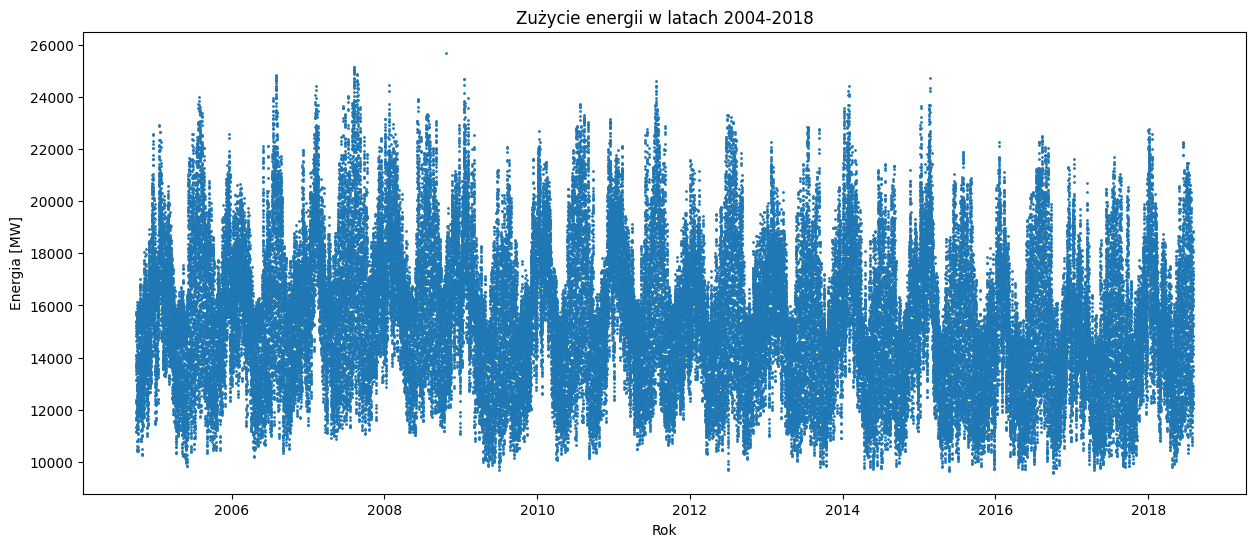

In [9]:
plt.figure(figsize=(15,6))
plt.plot(df.Datetime, df.AEP_MW, 'o', markersize=1)
plt.title('Zużycie energii w latach 2004-2018')
plt.xlabel('Rok')
plt.ylabel('Energia [MW]')
plt.savefig('A.png')
plt.show()

Dane możemy również zawęźić aby zoabczyć jaka jest zmienność np. w roku 2010. W tym celu filtrujemy dane z roku 2010 (od 01-01-2010 do 31-12-2010) poleceniem `.loc` i operacjami logicznymi `>` i `<=`.

In [10]:
df_2010=df.loc[(df.Datetime > '01-01-2010') & (df.Datetime <= '31-12-2010')]

W ramce `df_2010` mamy zapisane tylko wyniki z roku 2010. Zauważ, że index (pierwsza kolumna) nie zeruje się, ale przyjmuje wartości z ramki źródłowej.

In [11]:
df_2010

,Datetime,AEP_MW
46045,2010-12-30 01:00:00,16188.0
46046,2010-12-30 02:00:00,15780.0
46047,2010-12-30 03:00:00,15642.0
46048,2010-12-30 04:00:00,15565.0
46049,2010-12-30 05:00:00,15762.0
...,...,...
54773,2010-01-01 20:00:00,18590.0
54774,2010-01-01 21:00:00,18492.0
54775,2010-01-01 22:00:00,18466.0
54776,2010-01-01 23:00:00,18089.0


Resetowanie indeksu można zrobić komendą `.reset_index`, `drop=True` wyrzuca stare indeksy, `inplace=True` zamienia indeksy w ramce wywoływanej, czyli `df_2010` od razu będzie miała zapisane zmiany.

In [12]:
df_2010.reset_index(drop=True, inplace=True)

In [13]:
df_2010

,Datetime,AEP_MW
0,2010-12-30 01:00:00,16188.0
1,2010-12-30 02:00:00,15780.0
2,2010-12-30 03:00:00,15642.0
3,2010-12-30 04:00:00,15565.0
4,2010-12-30 05:00:00,15762.0
...,...,...
8728,2010-01-01 20:00:00,18590.0
8729,2010-01-01 21:00:00,18492.0
8730,2010-01-01 22:00:00,18466.0
8731,2010-01-01 23:00:00,18089.0


Wykonanie wykresu z danych `df_2010` jest analogiczne jak wyżej, zmienimy tytuł i orientację etykiet na osi `x` dla większej czytelności.

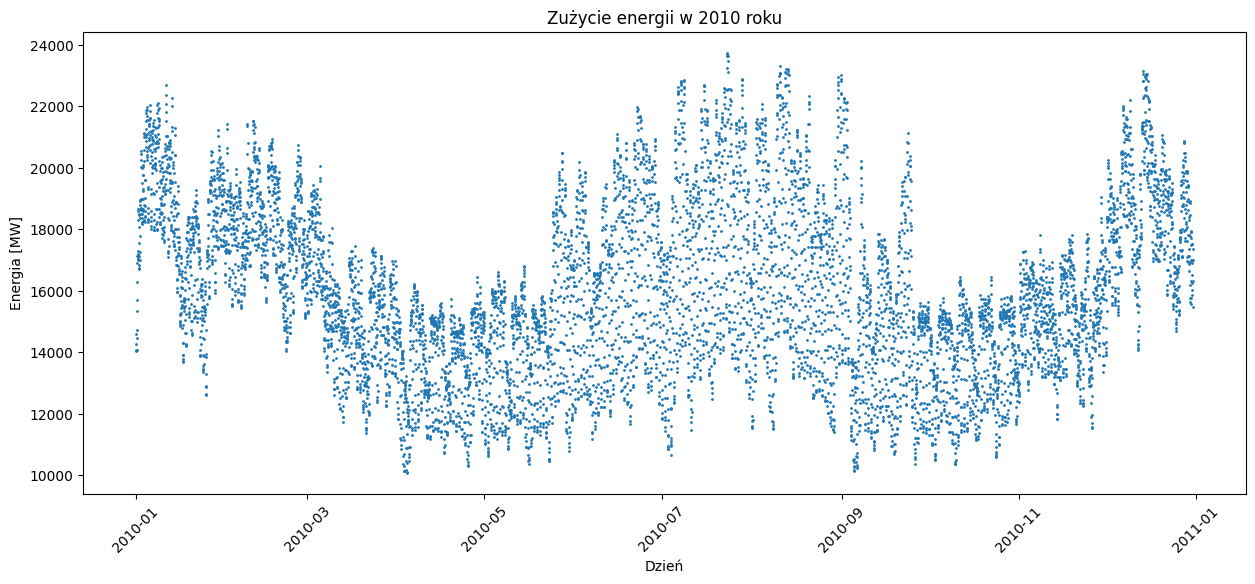

In [14]:
plt.figure(figsize=(15,6))
plt.plot(df_2010.Datetime, df_2010.AEP_MW, 'o', markersize=1)
plt.title('Zużycie energii w 2010 roku')
plt.xlabel('Dzień')
plt.ylabel('Energia [MW]')
plt.xticks(rotation=45)
plt.show()

# Przygotowanie danych do uczenia maszynowego, podział na dane treningowe i testowe

Dane zawarte w df mają mało atrybutów do uczenia maszynowego. Intuicyjnie wiemy, że zużycie energii może zależeć od następujących parametrów, takich jak godzina, dzień tygodnia, kwartał roku, miesiąc, rok, dzień roku czy dzień miesiąca. Do naszych danych w `df` dołożymy kolumny z poszczególnymi parametrami. Python umożliwia kilka możliwości ekstrakcji parametrów z dat. Tworzenie nowej kolumny w DataFrame jest bardzo proste, wystraczy podać nazwę ramki w której chcemy dołożyć kolumne oraz nazwę kolumny, np. do ramki `df` wstawiamy kolumnę o nazwie `hour` komendą `df['hour']`. Do jej zawartości przekierowujemy godzinę wyciągnięta z daty za pomocą komendy `.dt.hour`, czyli piszemy `df['Datetime'].dt.hour`, co wyciągnie nam z pełnej daty, tylko wartość godziny, czyli np. z daty `2004-12-31 01:00:00` otrzymamy `1`.

In [15]:
df['hour'] = df['Datetime'].dt.hour

Kolejne paramtery wyciągamy odpowiednimy komendami jak poniżej:

In [16]:
df['dayofweek'] = df['Datetime'].dt.dayofweek
df['quarter'] = df['Datetime'].dt.quarter
df['month'] = df['Datetime'].dt.month
df['year'] = df['Datetime'].dt.year
df['dayofyear'] = df['Datetime'].dt.dayofyear
df['dayofmonth'] = df['Datetime'].dt.day

Na koniec dostajemy rozszerzoną ramkę danych z odpowiednimi kolumnami.

In [17]:
df

,Datetime,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth
0,2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366,31
1,2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366,31
2,2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366,31
3,2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366,31
4,2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366,31
...,...,...,...,...,...,...,...,...,...
121268,2018-01-01 20:00:00,21089.0,20,0,1,1,2018,1,1
121269,2018-01-01 21:00:00,20999.0,21,0,1,1,2018,1,1
121270,2018-01-01 22:00:00,20820.0,22,0,1,1,2018,1,1
121271,2018-01-01 23:00:00,20415.0,23,0,1,1,2018,1,1


Teraz możemy zrobić wykres jak kształtowało się zużycie energii w ciągu całego okresu pomiarowego w poszczególnych godzinach. W tym celu użyjemy pakietu `seaborn`. Wykres możemy robić wg różnych parametrów, jak `month`, `year`, itp.

<ipython-input-18-5fc026d5f35a>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['hour'], y=df['AEP_MW'], palette='magma')


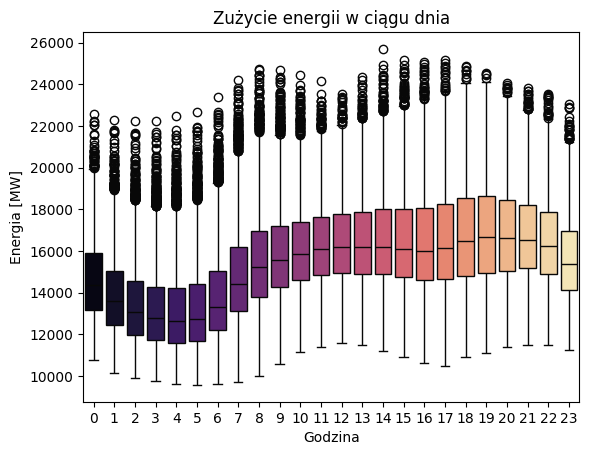

In [18]:
sns.boxplot(x=df['hour'], y=df['AEP_MW'], palette='magma')
plt.title('Zużycie energii w ciągu dnia')
plt.xlabel('Godzina')
plt.ylabel('Energia [MW]')
plt.show()

Przygotowanie danych do modelu rozpoczniemy od przygotowania danych zależnych (energia) i niezależnych (wszystko inne, czyli parametry czasowe. Nazwiemy jest odpowiednio `y` i `X`. Kolumny odrzucamy komendą `.drop`.



Dane treningowe i testowe dzielimy do/od dnia 01-01-2016, czyli to co przed rokiem 2016 jest w danych treiningowych i będzie używane do trenowania modelu uczenia maszynowego. To co powyżej tej daty będzie użyte do walidacji modelu.

In [19]:
df_train=df.loc[df['Datetime']< '01-01-2016']
df_test=df.loc[df['Datetime']>= '01-01-2016']

Następnie trzeba oddzielić zmienne niezależne (data, godzina, itp.) od zmiennych zależnych (energia). Odrzucamy też kolumne `'Datetime'`, która nie jest na już potrzebna.

In [20]:
X_train = df_train.drop(columns=['AEP_MW', 'Datetime'])
y_train = df_train['AEP_MW']

To samo trzeba zrobić dla danych testowych.

In [21]:
X_test = df_test.drop(columns=['AEP_MW', 'Datetime'])
y_test = df_test['AEP_MW']

Dane testowe `X_test`:

In [22]:
X_test

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth
89857,0,4,1,1,2016,1,1
98594,1,5,4,12,2016,366,31
98595,2,5,4,12,2016,366,31
98596,3,5,4,12,2016,366,31
98597,4,5,4,12,2016,366,31
...,...,...,...,...,...,...,...
121268,20,0,1,1,2018,1,1
121269,21,0,1,1,2018,1,1
121270,22,0,1,1,2018,1,1
121271,23,0,1,1,2018,1,1


Dane testowe `y_test`:

In [23]:
y_test

,AEP_MW
89857,13487.0
98594,14877.0
98595,14588.0
98596,14514.0
98597,14591.0
...,...
121268,21089.0
121269,20999.0
121270,20820.0
121271,20415.0


# Uczenie maszynowe - model XGBoost

Model uczenia maszynowego budujemy w oparciu o `xgb`, koszystamy z modelu regresji `XGBRegresor` podając ile kroków uczenia maszynowego ma wykonać. Zwiększając ilość kroków zwiększamy dokładność modelu, ale wydłużamy czas obliczeń. Można przetestować dla różnych wartości `n`. Nie zawsze więcej znaczy lepiej, ponieważ model może być zbyt mocno dopasowany do danych treningowych i będzie źle przewidywał w oparciu o dane testowe, zwiększając błąd.

In [63]:
reg = xgb.XGBRegressor(n_estimators=200)

Uruchamiamy uczenie modelu komendą fit

In [64]:
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:2131.56898	validation_1-rmse:2232.07094
[100]	validation_0-rmse:707.95074	validation_1-rmse:2020.26986
[199]	validation_0-rmse:539.08151	validation_1-rmse:2051.28446


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Wartości z predykcji uzyskane komendą `reg.predict` z danych testowych `X_test` zostaną zapisane w kolumnie o nazwie `prediction` w ramce danych `df_test`.

In [65]:
df_test['prediction'] = reg.predict(X_test)

<ipython-input-65-b916bed4e230>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prediction'] = reg.predict(X_test)


In [66]:
df_test

,Datetime,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,prediction
89857,2016-01-01 00:00:00,13487.0,0,4,1,1,2016,1,1,15142.793945
98594,2016-12-31 01:00:00,14877.0,1,5,4,12,2016,366,31,11541.394531
98595,2016-12-31 02:00:00,14588.0,2,5,4,12,2016,366,31,11295.641602
98596,2016-12-31 03:00:00,14514.0,3,5,4,12,2016,366,31,11105.570312
98597,2016-12-31 04:00:00,14591.0,4,5,4,12,2016,366,31,11110.251953
...,...,...,...,...,...,...,...,...,...,...
121268,2018-01-01 20:00:00,21089.0,20,0,1,1,2018,1,1,16821.859375
121269,2018-01-01 21:00:00,20999.0,21,0,1,1,2018,1,1,16626.345703
121270,2018-01-01 22:00:00,20820.0,22,0,1,1,2018,1,1,16234.525391
121271,2018-01-01 23:00:00,20415.0,23,0,1,1,2018,1,1,15498.868164


# Ocena modelu

Wykres predykcji na tle wszystkich danych jest zrobiony poniżej. Druga i trzecia linijka kodu to generowanie wykresu.

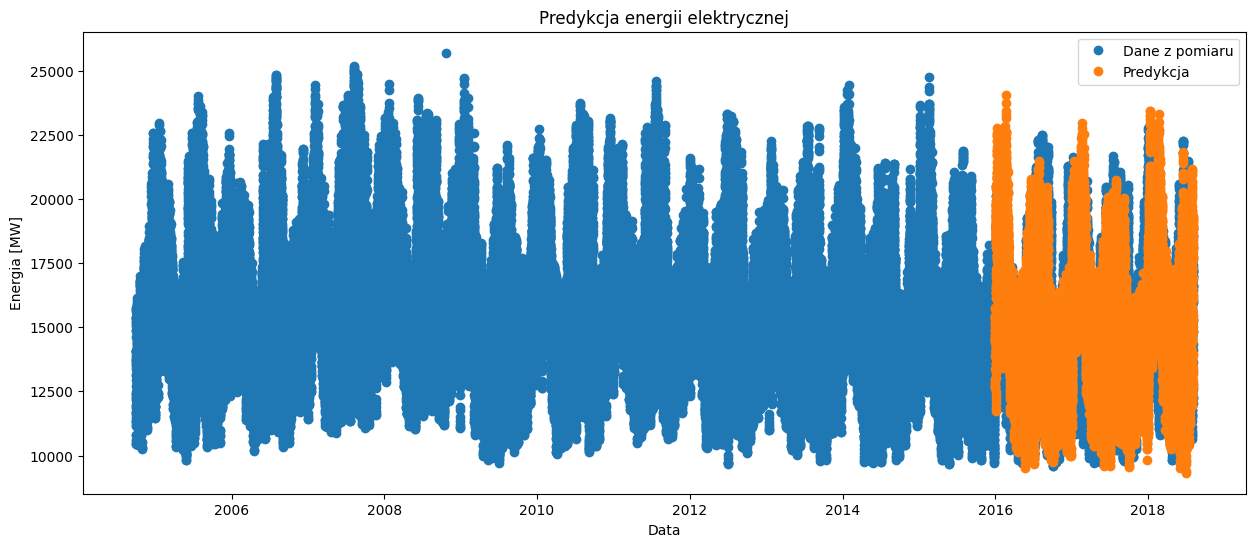

In [67]:
plt.figure(figsize=(15,6))

plt.plot(df['Datetime'], df['AEP_MW'], 'o', label='Dane z pomiaru')
plt.plot(df_test['Datetime'], df_test['prediction'], 'o', label='Predykcja')

plt.title('Predykcja energii elektrycznej')
plt.xlabel('Data')
plt.ylabel('Energia [MW]')
plt.legend()
plt.show()

Z modelu `reg` możemy również wyciągnąć istotność parametrów użytych do przewidywania produkcji/zużycia energii elektrycznej. Używamy komendy `feature_importances_` oraz `reg.feature_names_in_`. Utworzymy nową ramkę danych o nazwie `fi`.

In [68]:
reg.feature_importances_

array([0.33990416, 0.12377451, 0.09100933, 0.09209573, 0.08148223,
       0.22896022, 0.04277385], dtype=float32)

In [69]:
reg.feature_names_in_

array(['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth'], dtype='<U10')

In [70]:
fi = pd.DataFrame()

In [71]:
fi['Składnik'] = reg.feature_names_in_
fi['Ważność'] = reg.feature_importances_

In [72]:
fi.sort_values('Ważność', inplace=True)

In [73]:
fi

,Składnik,Ważność
6,dayofmonth,0.042774
4,year,0.081482
2,quarter,0.091009
3,month,0.092096
1,dayofweek,0.123775
5,dayofyear,0.228960
0,hour,0.339904


Z podanych danych można zrobić wykres słupkowy.

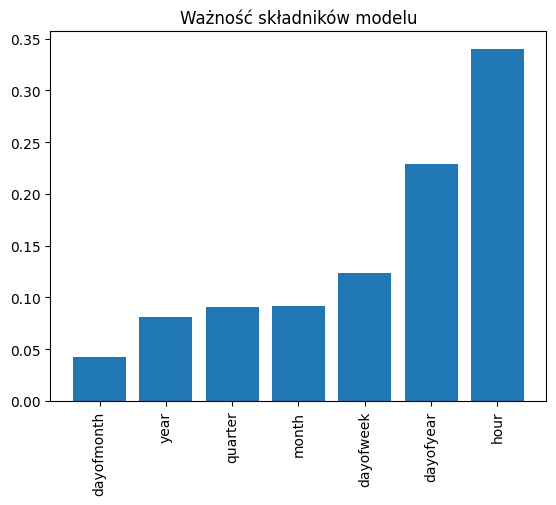

In [74]:
plt.bar(fi['Składnik'], height=fi['Ważność'])
plt.title('Ważność składników modelu')
plt.xticks(rotation=90)
plt.show()

Metrykę błędu progonozy można zrobić w oparciu o MSE, o czym było na początku tego pliku. Składnia jest prosta, `mean_squared_error(df_test['AEP_MW'], df_test['prediction'])`

In [75]:
score = mean_squared_error(df_test['AEP_MW'], df_test['prediction'])
print(f'MSE Score on Test set: {score:0.2f}')

MSE Score on Test set: 4207767.94


Wartość może wydawać się duża, ale jak odniesiemy ją na godzinę pomiaru to będzie bardziej mariodajne.

In [76]:
print(f'MSE per hour: %.3f MW' % (score/df_test.size))

MSE per hour: 18.553 MW
